In [ ]:
%cd vaccinate_zindi

In [ ]:
import os
import string
import time
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torchtext.legacy import data

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
Train = pd.read_csv('Train.csv')
print('Label Unique: ',Train.label.unique())
print('Agreement Unique' , Train.agreement.unique())
Train = Train.dropna()
Train.label = Train.label.astype('int')
print('Label Unique: ',Train.label.unique(), Train.label.nunique())

Test = pd.read_csv('Test.csv')
sub = pd.read_csv('SampleSubmission.csv')

s = int(len(Train) * 0.2)
Train[['safe_text', 'label']][s:].to_csv('train_work.csv', index = False)
Train[['safe_text', 'label']][:s].to_csv('valid_work.csv', index = False)
Test[['safe_text']].to_csv('test_work.csv', index = False)

display(Train.head())
print('max length: ', max([len(row.split()) for row in Train.safe_text]))
print('aggrement unique: ', Train.agreement.nunique())
display(sub.head())

Label Unique:  [ 0.          1.         -1.                 nan  0.66666667]
Agreement Unique [1.         0.66666667 0.33333333        nan]
Label Unique:  [ 0  1 -1] 3


,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0,1.0


max length:  33
aggrement unique:  3


,tweet_id,label
0,00BHHHP1,0
1,00UNMD0E,0
2,01AXPTJF,0
3,01HOEQJW,0
4,01JUKMAO,0


In [ ]:
tokenizer = lambda x: str(x).translate(str.maketrans('', '', string.punctuation)).strip().split()
TEXT = data.Field(sequential = True, include_lengths=True, batch_first=True ,tokenize = tokenizer, fix_length = 100)
LABEL = data.Field(sequential = False, use_vocab = False, unk_token=None)
fields = [('safe_text', TEXT), ('label', LABEL)]
BATCH_SIZE = 64

train, valid, test = data.TabularDataset.splits(path = './', train= 'train_work.csv',
                                                validation = 'valid_work.csv', test = 'test_work.csv',
                                                format = 'csv', fields = fields, skip_header = True )

TEXT.build_vocab(train, max_size = 30_000)
LABEL.build_vocab(train)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#train_iter, valid_iter, test_iter = data.BucketIterator.splits((train, valid, test), batch_size = BATCH_SIZE)

#iterator
train_iter = data.BucketIterator(train, device= device, batch_size= BATCH_SIZE, 
                                  sort_key=lambda x: len(x.safe_text), sort_within_batch = True, repeat = False, shuffle = True)
valid_iter = data.BucketIterator(valid, device = device, batch_size =BATCH_SIZE, shuffle = True,
                                  sort_key=lambda x:len(x.safe_text), sort_within_batch = True, repeat = False)
test_iter = data.BucketIterator(test, device = device, batch_size =1, sort_key = lambda x: len(x.safe_text),
                                sort_within_batch= True, repeat = False)


In [ ]:
#TEXT.vocab.stoi
#TEXT.vocab.itos
print(LABEL.vocab.stoi)
TEXT.vocab.freqs.most_common(5)

defaultdict(None, {'0': 0, '1': 1, '-1': 2})


[('user', 3849), ('url', 3700), ('to', 2727), ('the', 2717), ('measles', 1995)]

In [ ]:
# first model

class GRU(nn.Module):
    def __init__(self, vocab_size,embedding_dim, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(GRU, self).__init__()
        
    
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.output_size = output_size
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_size, self.n_layers, 
                          dropout=(0 if n_layers ==1 else dropout), bidirectional=True)#batch_first = True,
        self.lin = nn.Linear(self.hidden_size * 2, self.output_size)
        
    def forward(self, input_seqs, input_lengths):
        embedded = self.dropout(self.embedding(input_seqs)) #[batch_size, seq_len, emb_dim]
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, enforce_sorted=True, batch_first=True)
        outputs, hidden = self.gru(packed)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        #output -- [batch_siize, seq_len, hid_dim * n_directions]
        #hidden --- [n_layers* n_directions, batch_size, hid_dim]
        #sum through n_directions
        out = torch.cat((hidden[-2,:, :], hidden[-1, :, :]), dim =1)  # Sum bidirectional outputs
        #out -- [batch_size, hid_dim * n_directions]
        out = self.dropout(self.lin(out))
        #out -- [batch_size, output_size]
        return F.tanh(out)

        

In [ ]:
# model 2

# first model

class LSTM(nn.Module):
    def __init__(self, vocab_size,embedding_dim, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LSTM, self).__init__()
        
    
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.output_size = output_size
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_size, self.n_layers, 
                          dropout=(0 if n_layers ==1 else dropout), bidirectional=True)#batch_first = True,
        self.lin = nn.Linear(self.hidden_size * 2, self.output_size)
        
    def forward(self, input_seqs, input_lengths):
        embedded = self.dropout(self.embedding(input_seqs)) #[batch_size, seq_len, emb_dim]
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, enforce_sorted=True, batch_first=True)
        outputs, (hidden, cell) = self.lstm(packed)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        #sum through n_directions
        out = torch.cat((hidden[-2,:, :], hidden[-1, :, :]), dim =1)  # Sum bidirectional outputs
        #out -- [batch_size, hid_dim * n_directions]
        out = self.dropout(self.lin(out))
        #out -- [batch_size, output_size]
        return F.tanh(out)
        

In [ ]:
#model

class BiGRU(nn.Module):
  def __init__(self, hidden_size, vocab_size, embedding_dim, output_size, n_layers=1, dropout = 0.2,
                bidirectional = True):
      super(BiGRU, self).__init__()

      self.hidden_size = hidden_size
      self.vocab_size = vocab_size
      self.embedding_dim = embedding_dim
      self.output_size = output_size
      self.n_layers = n_layers
      self.dropout = dropout
      self.bidirectional = bidirectional
      self.n_directions = 2 #if self.bidirectional else 1

      self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
      self.dropout = nn.Dropout(self.dropout)
      self.gru = nn.GRU(self.embedding_dim, self.hidden_size, num_layers = self.n_layers, 
                        dropout =(0 if n_layers ==1 else dropout), batch_first = True, 
                        bidirectional = self.bidirectional)
      self.lin = nn.Linear(self.hidden_size * 3, self.output_size)

  def forward(self, input_seq, input_length, hidden = None):
      self.batch_size = input_seq.size(0) # [batch_size, seq_length]
      emb_out = self.embedding(input_seq) # [batch_size, seq_length, embedding_dim]
      out = self.dropout(emb_out)

      #pack padded batch # []
      packed_out = nn.utils.rnn.pack_padded_sequence(out, input_length, enforce_sorted=True, batch_first=True)
      # [batch_size, seq_length, hidden_size * num_directions]
      #hidden is zero if not provided
      gru_out, hidden = self.gru(packed_out, hidden)
      #bidirection GRU; is the sum of forward and backward GRU representation
      #Work on hidden shape
      hidden = hidden.view(self.n_layers, self.n_directions, self.batch_size, self.hidden_size)
      last_hidden = hidden[-1]
      last_hidden = torch.sum(last_hidden, dim=0) # [batch_size, hidden_size]
      gru_out, lengths = nn.utils.rnn.pad_packed_sequence(gru_out, batch_first=True)
      # [batch_size, seq_length, hidden_state * n_directions]
      # Sum the gru_out along the num_directions
      if self.bidirectional:
          gru_out = gru_out[:, :, :self.hidden_size] + gru_out[:,:, self.hidden_size:] # sum bidirectional output
      max_pool = F.adaptive_max_pool1d(gru_out.permute(0,2,1), (1,)).view(self.batch_size, -1)
      avg_pool = torch.sum(gru_out, dim =1) / lengths.view(-1,1).type(torch.FloatTensor)
      concat = torch.cat([last_hidden, max_pool, avg_pool], dim =1)
      out = self.lin(concat)
      return F.tanh(out)


In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
      super().__init__()
      self.mse = nn.MSELoss()

    def forward(self, yhat, y):
      return torch.sqrt(self.mse(yhat, y))

In [ ]:
vocab_size = len(TEXT.vocab)
hidden_size = 356
embedding_dim = 150
output_size = 1
n_layers=3
dropout = 0.6
learning_rate = 0.000001 #0.000001 
epochs = 50

model1 = GRU(vocab_size,embedding_dim, hidden_size, output_size, n_layers, dropout)
criterion1 = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr =learning_rate)

model2 = LSTM(vocab_size,embedding_dim, hidden_size, output_size, n_layers, dropout)
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr =learning_rate)

model = BiGRU(hidden_size, vocab_size, embedding_dim, output_size, n_layers, dropout,
               bidirectional = True)
#criterion = RMSELoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr =learning_rate)

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#model.to(device)


In [ ]:
#pretrained_embeddings = TEXT.vocab.vectors
#model.embedding.weight.data.copy_(pretrained_embeddings)

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
model.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)

In [ ]:
def categorical_accuracy(preds, y):
    '''Returns accuracy per batch, if 9/10, it returns 0.9'''
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss =0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, input_length = batch.safe_text
        out = model(text, input_length).squeeze(1)
        loss = criterion(out.float(), batch.label.float())
        #acc = categorical_accuracy(out, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #epoch_acc += acc.item()

    return epoch_loss / len(iterator) #epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss =0
    epoch_acc =0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, input_length = batch.safe_text
            out = model(text, input_length)
            loss = criterion(out.float(), batch.label.float())
            #acc = categorical_accuracy(out, batch.label)
            epoch_loss += loss.item()
            #epoch_acc += acc.item()

    return epoch_loss / len(iterator) #epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins *60))
    return elapsed_mins, elapsed_secs

In [ ]:
n_epochs = 10
start_iter = 1
best_valid_loss = float('inf')

checkpointm1 = False
if checkpointm1:
    checkpoint = torch.load('checkpoint_vaccinate_model1.tar')  
    m = checkpoint['model']
    model1.load_state_dict(m)
    start_iter = checkpoint['iterator']
    best_valid_loss = checkpoint['loss']


checkpointm2 = False
if checkpointm2:
    checkpoint = torch.load('checkpoint_vaccinate_model2.tar')  
    m = checkpoint['model']
    model2.load_state_dict(m)
    start_iter = checkpoint['iterator']
    best_valid_loss = checkpoint['loss']


checkpointm = False
if checkpointm1:
    checkpoint = torch.load('checkpoint_vaccinate.tar')  
    m = checkpoint['model']
    model.load_state_dict(m)
    start_iter = checkpoint['iterator']
    best_valid_loss = checkpoint['loss']


In [ ]:
#model

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(start_iter, n_epochs+start_iter):
    start_time = time.time()

    train_loss = train(model, train_iter, optimizer, criterion)
    valid_loss = evaluate(model, valid_iter, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({'model': model.state_dict(), 'iterator': epoch, 'loss': best_valid_loss}, 'checkpoint_vaccinate.tar')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch:02} | Epoch Time {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss: .3f} |  Val Loss: {valid_loss: .3f}')
   # print(f'\t  Train Acc: {train_acc * 100: .2f}% | Val Acc: {valid_acc * 100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 01 | Epoch Time 1m 59s
	 Train Loss:  0.519 |  Val Loss:  0.514
Epoch: 02 | Epoch Time 1m 58s
	 Train Loss:  0.515 |  Val Loss:  0.508
Epoch: 03 | Epoch Time 1m 58s
	 Train Loss:  0.510 |  Val Loss:  0.502
Epoch: 04 | Epoch Time 1m 58s
	 Train Loss:  0.508 |  Val Loss:  0.501
Epoch: 05 | Epoch Time 1m 58s
	 Train Loss:  0.505 |  Val Loss:  0.496
Epoch: 06 | Epoch Time 1m 58s
	 Train Loss:  0.500 |  Val Loss:  0.492
Epoch: 07 | Epoch Time 1m 59s
	 Train Loss:  0.498 |  Val Loss:  0.489
Epoch: 08 | Epoch Time 1m 59s
	 Train Loss:  0.494 |  Val Loss:  0.485
Epoch: 09 | Epoch Time 1m 59s
	 Train Loss:  0.488 |  Val Loss:  0.482
Epoch: 10 | Epoch Time 1m 58s
	 Train Loss:  0.485 |  Val Loss:  0.479


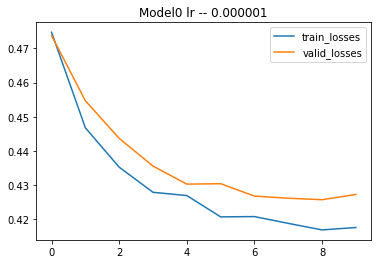

In [ ]:
fig, ax = plt.subplots()
#ax.plot(train_accs, label ='train_accs')
#ax.plot(valid_accs, label ='valid_accs')
ax.plot(train_losses, label = 'train_losses' )
ax.plot(valid_losses, label = 'valid_losses')
ax.set_title('Model0 lr -- 0.000001')
ax.legend()

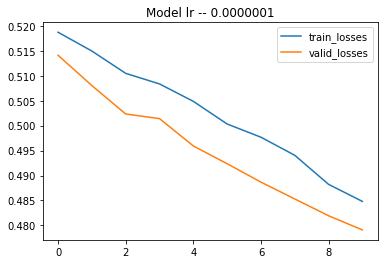

In [ ]:
fig, ax = plt.subplots()
#ax.plot(train_accs, label ='train_accs')
#ax.plot(valid_accs, label ='valid_accs')
ax.plot(train_losses, label = 'train_losses' )
ax.plot(valid_losses, label = 'valid_losses')
ax.set_title('Model0 lr -- 0.0000001')
ax.legend()

In [ ]:
#model1

train_losses = []
valid_losses = []

for epoch in range(start_iter, n_epochs+start_iter):
    start_time = time.time()

    train_loss = train(model1, train_iter, optimizer1, criterion1)
    valid_loss = evaluate(model1, valid_iter, criterion1)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({'model': model.state_dict(), 'iterator': epoch, 'loss': best_valid_loss}, 'checkpoint_vaccinate_model1.tar')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch:02} | Epoch Time {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss: .3f} |  Val Loss: {valid_loss: .3f}')
   # print(f'\t  Train Acc: {train_acc * 100: .2f}% | Val Acc: {valid_acc * 100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 01 | Epoch Time 1m 57s
	 Train Loss:  0.536 |  Val Loss:  0.506
Epoch: 02 | Epoch Time 1m 57s
	 Train Loss:  0.538 |  Val Loss:  0.502
Epoch: 03 | Epoch Time 1m 57s
	 Train Loss:  0.536 |  Val Loss:  0.500
Epoch: 04 | Epoch Time 1m 56s
	 Train Loss:  0.531 |  Val Loss:  0.499
Epoch: 05 | Epoch Time 1m 56s
	 Train Loss:  0.534 |  Val Loss:  0.499
Epoch: 06 | Epoch Time 1m 58s
	 Train Loss:  0.532 |  Val Loss:  0.496
Epoch: 07 | Epoch Time 1m 58s
	 Train Loss:  0.527 |  Val Loss:  0.495
Epoch: 08 | Epoch Time 1m 58s
	 Train Loss:  0.526 |  Val Loss:  0.493
Epoch: 09 | Epoch Time 1m 59s
	 Train Loss:  0.523 |  Val Loss:  0.489
Epoch: 10 | Epoch Time 1m 59s
	 Train Loss:  0.524 |  Val Loss:  0.488


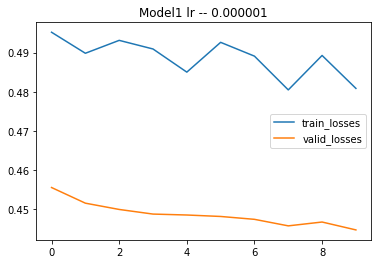

In [ ]:
fig, ax = plt.subplots()
#ax.plot(train_accs, label ='train_accs')
#ax.plot(valid_accs, label ='valid_accs')
ax.plot(train_losses, label = 'train_losses' )
ax.plot(valid_losses, label = 'valid_losses')
ax.set_title('Model1 lr -- 0.000001')
ax.legend()

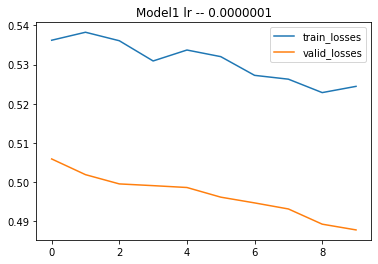

In [ ]:
fig, ax = plt.subplots()
#ax.plot(train_accs, label ='train_accs')
#ax.plot(valid_accs, label ='valid_accs')
ax.plot(train_losses, label = 'train_losses' )
ax.plot(valid_losses, label = 'valid_losses')
ax.set_title('Model1 lr -- 0.0000001')
ax.legend()

In [ ]:
#model1

train_losses = []
valid_losses = []

for epoch in range(start_iter, n_epochs+start_iter):
    start_time = time.time()

    train_loss = train(model2, train_iter, optimizer2, criterion2)
    valid_loss = evaluate(model2, valid_iter, criterion2)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({'model': model.state_dict(), 'iterator': epoch, 'loss': best_valid_loss}, 'checkpoint_vaccinate_model2.tar')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch:02} | Epoch Time {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss: .3f} |  Val Loss: {valid_loss: .3f}')
   # print(f'\t  Train Acc: {train_acc * 100: .2f}% | Val Acc: {valid_acc * 100:.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 01 | Epoch Time 2m 34s
	 Train Loss:  0.505 |  Val Loss:  0.497
Epoch: 02 | Epoch Time 2m 34s
	 Train Loss:  0.495 |  Val Loss:  0.491
Epoch: 03 | Epoch Time 2m 34s
	 Train Loss:  0.489 |  Val Loss:  0.483
Epoch: 04 | Epoch Time 2m 33s
	 Train Loss:  0.486 |  Val Loss:  0.476
Epoch: 05 | Epoch Time 2m 33s
	 Train Loss:  0.480 |  Val Loss:  0.470
Epoch: 06 | Epoch Time 2m 33s
	 Train Loss:  0.478 |  Val Loss:  0.466
Epoch: 07 | Epoch Time 2m 34s
	 Train Loss:  0.478 |  Val Loss:  0.464
Epoch: 08 | Epoch Time 2m 35s
	 Train Loss:  0.478 |  Val Loss:  0.459
Epoch: 09 | Epoch Time 2m 34s
	 Train Loss:  0.476 |  Val Loss:  0.459
Epoch: 10 | Epoch Time 2m 35s
	 Train Loss:  0.474 |  Val Loss:  0.456


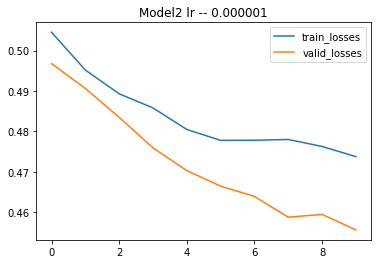

In [ ]:
fig, ax = plt.subplots()
#ax.plot(train_accs, label ='train_accs')
#ax.plot(valid_accs, label ='valid_accs')
ax.plot(train_losses, label = 'train_losses' )
ax.plot(valid_losses, label = 'valid_losses')
ax.set_title('Model2 lr -- 0.000001')
ax.legend()